In [1]:
import pandas as pd
import numpy as np
import wrangle, scale, explore, cluster
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 30% of its data
zillow = wrangle.drop_null_columns(zillow,30)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 60% of its data
zillow = wrangle.drop_null_rows(zillow, 70)

In [7]:
#drop remaining data
zillow = zillow.dropna()

In [8]:
zillow.isna().sum().sum()

0

In [9]:
zillow.shape

(64065, 30)

In [10]:
for i in zillow.columns:
    print(zillow[i].value_counts())

261.0    50560
266.0    11316
269.0     1767
265.0      311
263.0       58
267.0       29
275.0        9
260.0        9
246.0        5
264.0        1
Name: propertylandusetypeid, dtype: int64
12551841    1
13909805    1
11919121    1
11388690    1
12838678    1
           ..
17051872    1
13096111    1
11582003    1
12715912    1
12853244    1
Name: parcelid, Length: 64065, dtype: int64
0        1
7529     1
73033    1
66890    1
68939    1
        ..
39494    1
37447    1
59976    1
62027    1
2047     1
Name: id, Length: 64065, dtype: int64
0.002652    7
0.000231    7
0.008257    5
0.006909    5
0.003152    5
           ..
0.033095    1
0.423427    1
0.020736    1
0.046424    1
0.025578    1
Name: logerror, Length: 63643, dtype: int64
2017-06-30    975
2017-04-28    758
2017-05-31    716
2017-07-28    686
2017-03-31    650
             ... 
2017-03-25      1
2018-05-25      1
2017-09-02      1
2017-02-18      1
2017-08-13      1
Name: transactiondate, Length: 263, dtype: int64
223232

### Feature Engineering 

In [11]:
zillow = wrangle.zillow_engineering(zillow)

In [12]:
#filter by single unit housing
zillow = zillow[(zillow.propertylandusedesc == 'Single Family Residential') |
          (zillow.propertylandusedesc == 'Mobile Home') |
          (zillow.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (zillow.propertylandusedesc == 'Townhouse')]
zillow.shape

(50628, 32)

In [13]:
zillow.columns

Index(['propertylandusetypeid', 'parcelid', 'id', 'logerror',
       'transactiondate', 'id.1', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'propertylandusedesc', 'taxrate',
       'transactionmonth'],
      dtype='object')

## Split/Scale

In [14]:
train , validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12'])

train(28351, 32),validate(12151, 32),test(10126, 32)


## Explore

### Exploring Variables in relation to Target = Log Error

In [15]:
cont_vars = ['logerror','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip']
target = 'logerror'

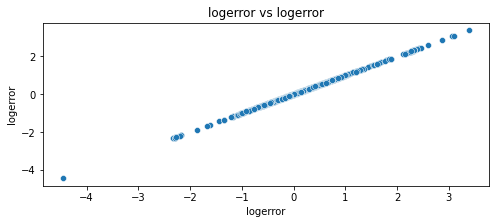

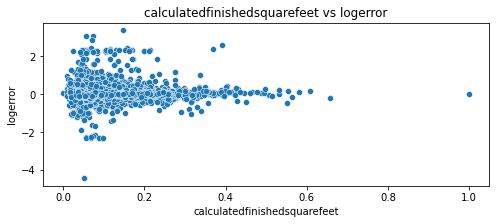

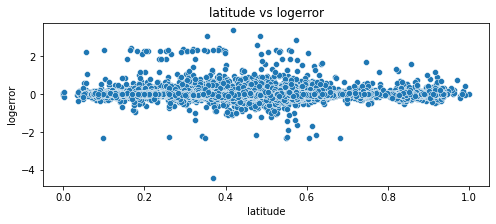

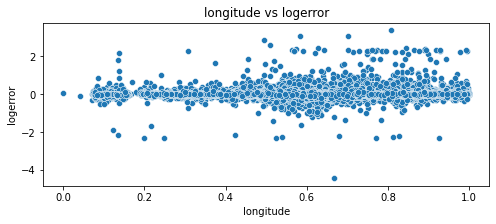

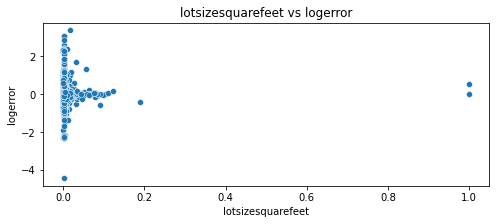

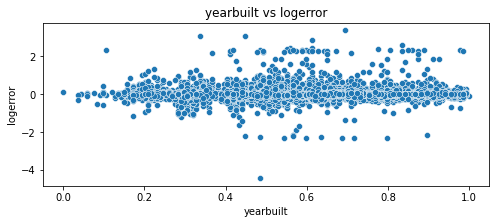

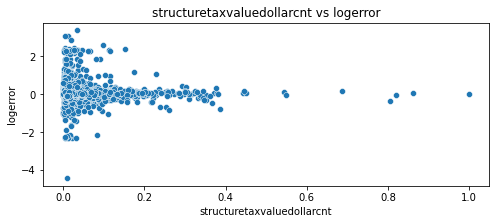

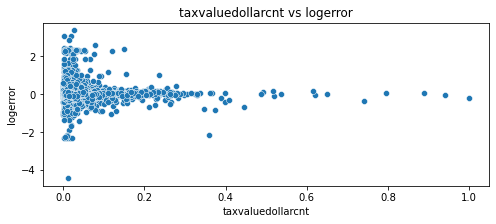

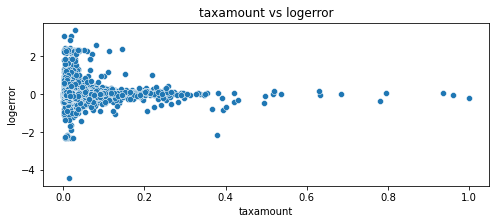

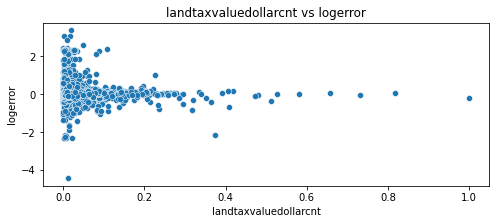

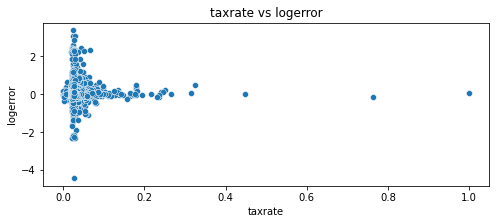

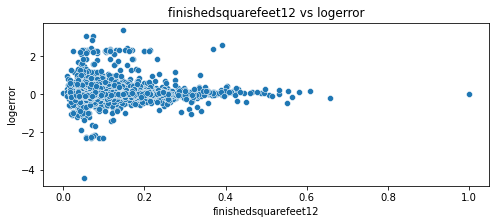

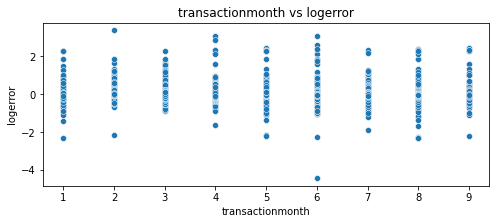

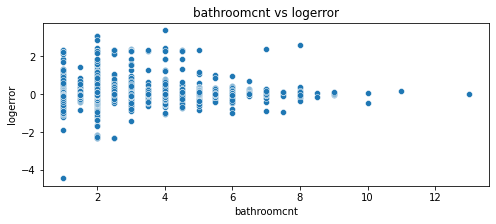

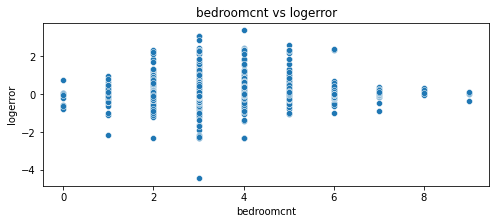

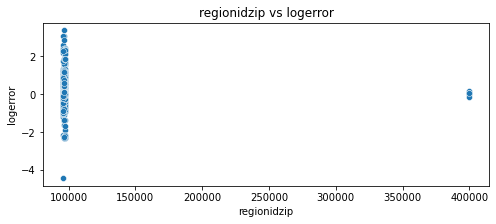

In [16]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, and Age of the house play a big role in Log Error 
- The more houses are similar to eachother in terms of these 3 main topics , the harder it is to predict there price accurately
    * Why? because as it stands, Our dataset doesnt have these vaariables grouped in a meaningful way.
    * latitide and logitude are too unique for the computer to understand how they realate even if the houses were right next to eachother.
     Buit with the help of these 3 main variables, the value of the house 
- we will look more into location vs price vs size , cluster these and see if these types of houses prioritize diffrent drivers for predicting logerror and model to their needs for a possibly better Predicitons

## Target = Logerror 

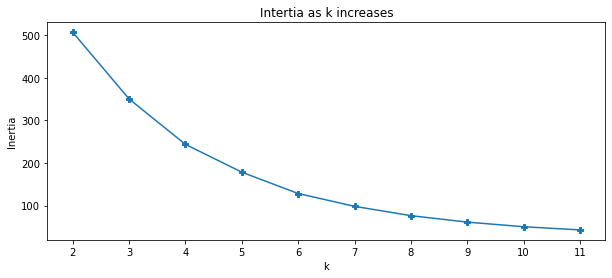

In [17]:
X = train_scaled[['logerror']]
cluster.view_intertia(X)

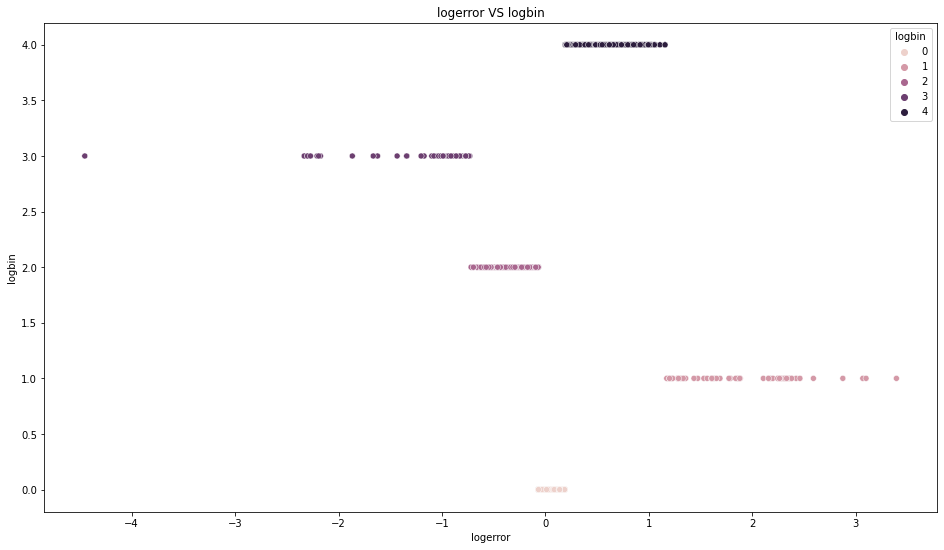

In [18]:
X = cluster.show_cluster(X, 5, 'logbin')

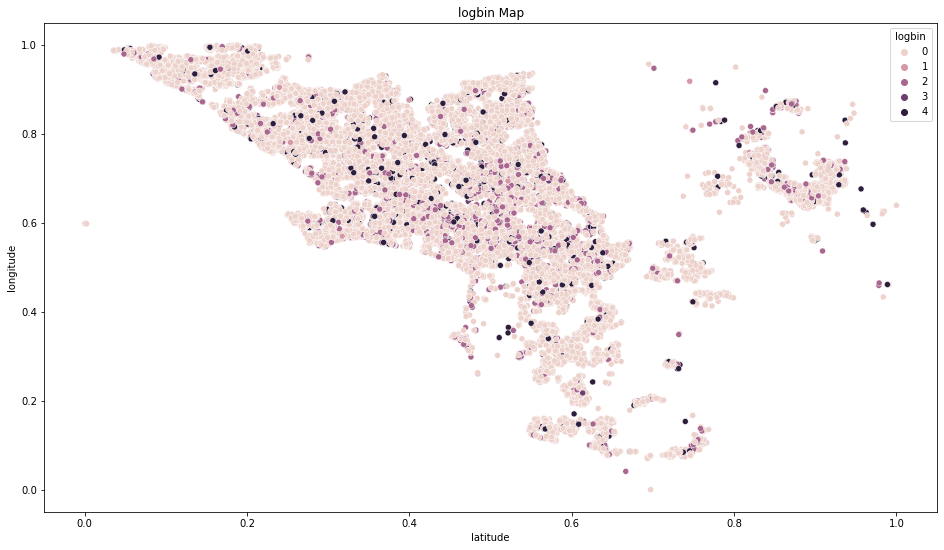

In [19]:
train_scaled['logbin'] = X['logbin']
cluster.map_clusters(train_scaled, 'logbin')

### Price

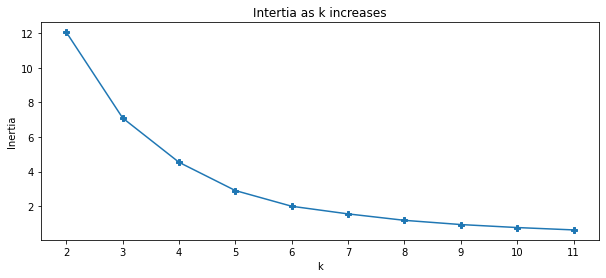

In [20]:
X = train_scaled[['taxvaluedollarcnt']]
cluster.view_intertia(X)

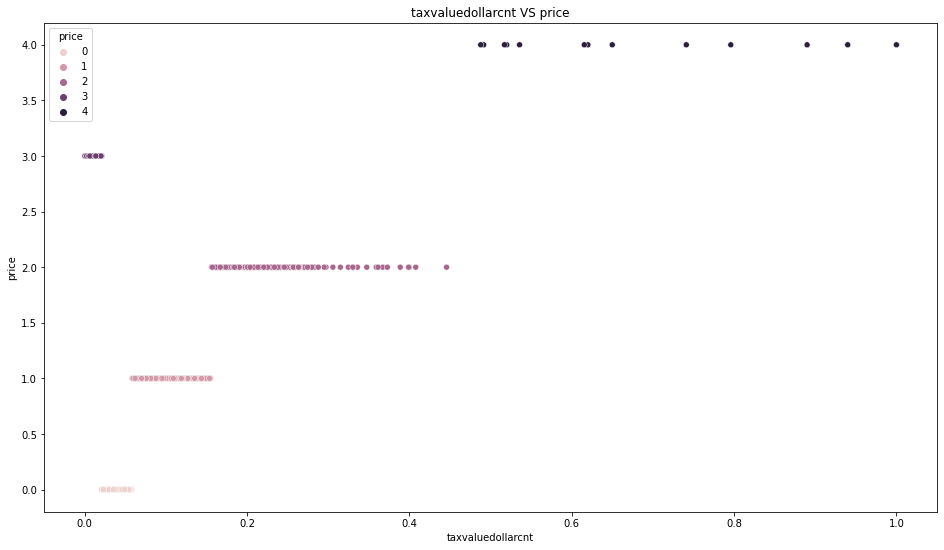

In [21]:
X = cluster.show_cluster(X, 5, 'price')

In [22]:
#Add clusters onto existing training dataset
train_scaled['price'] = X['price']

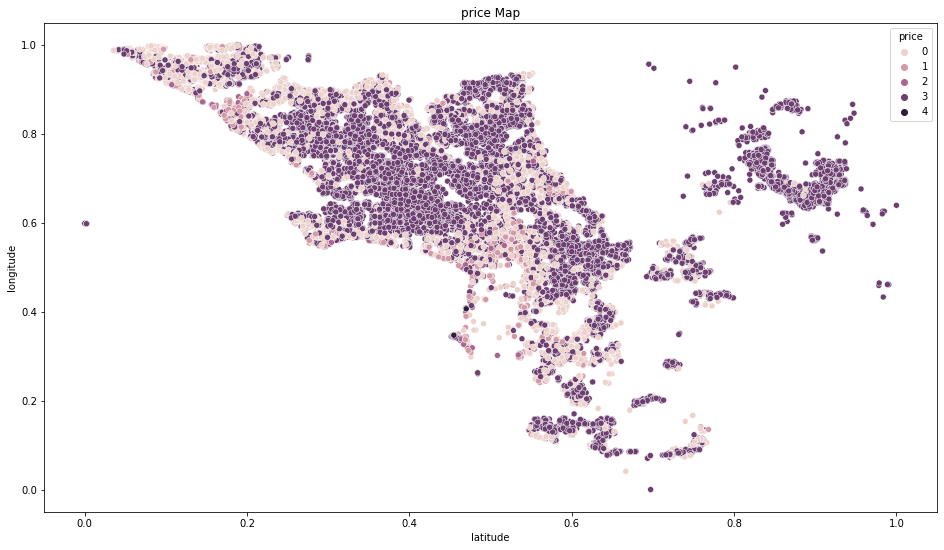

In [23]:
cluster.map_clusters(train_scaled, 'price')

In [24]:
train_scaled.columns

Index(['propertylandusetypeid', 'parcelid', 'id', 'logerror',
       'transactiondate', 'id.1', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'propertylandusedesc', 'taxrate',
       'transactionmonth', 'logbin', 'price'],
      dtype='object')

### Size

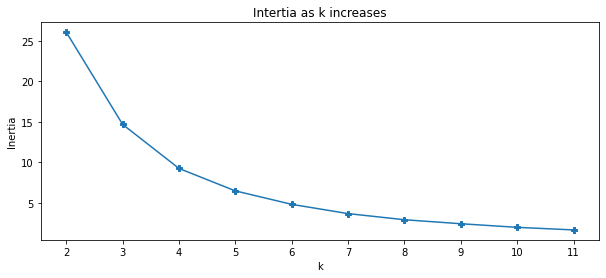

In [25]:
X = train_scaled[['calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

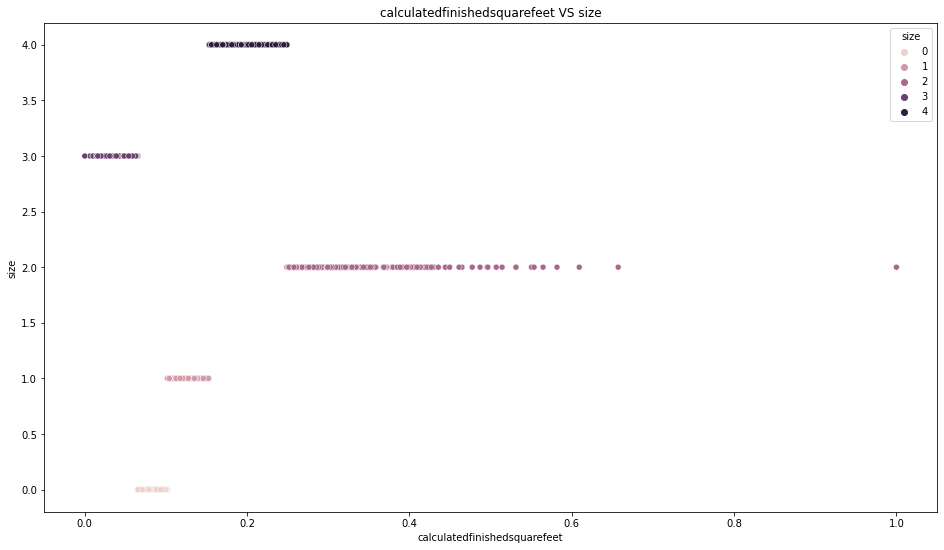

In [26]:
X = cluster.show_cluster(X, 5, 'size')

In [27]:
train_scaled['size'] = X['size']

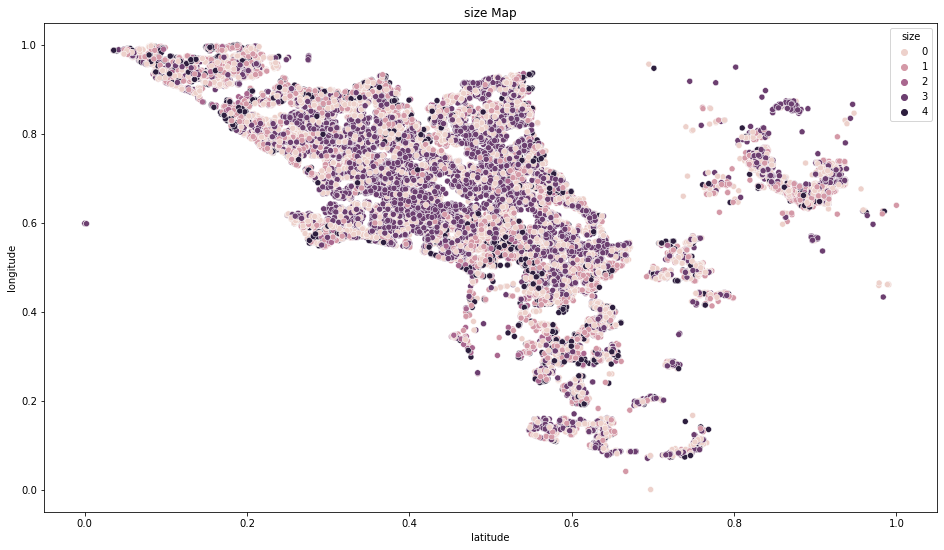

In [28]:
cluster.map_clusters(train_scaled, 'size')

### Age

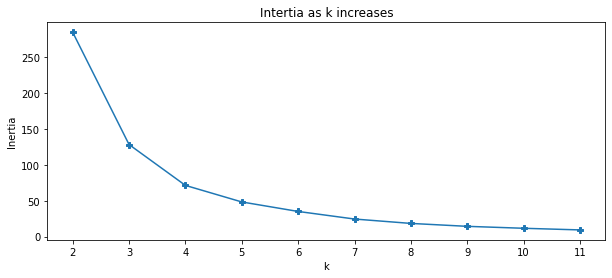

In [29]:
X = train_scaled[['yearbuilt']]
cluster.view_intertia(X)

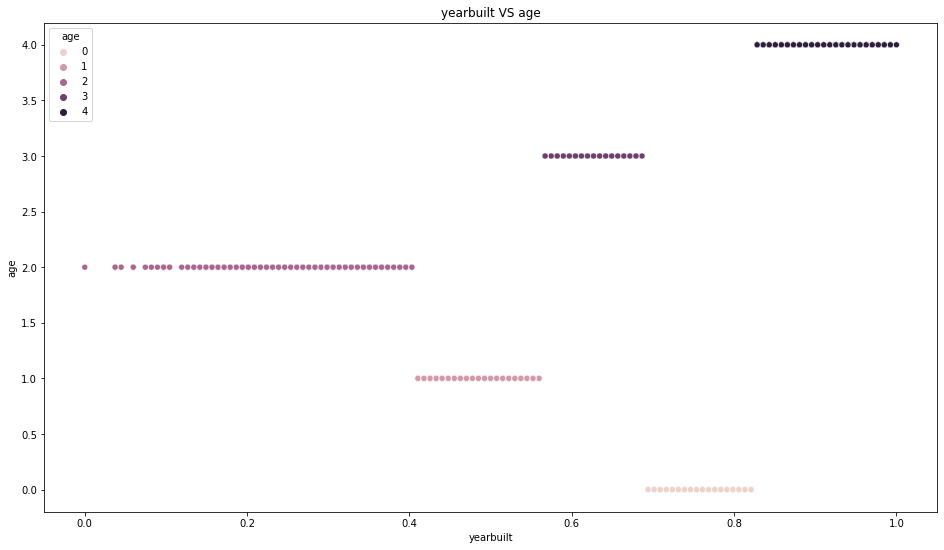

In [30]:
X = cluster.show_cluster(X, 5, 'age')

In [31]:
train_scaled['age'] = X['age']

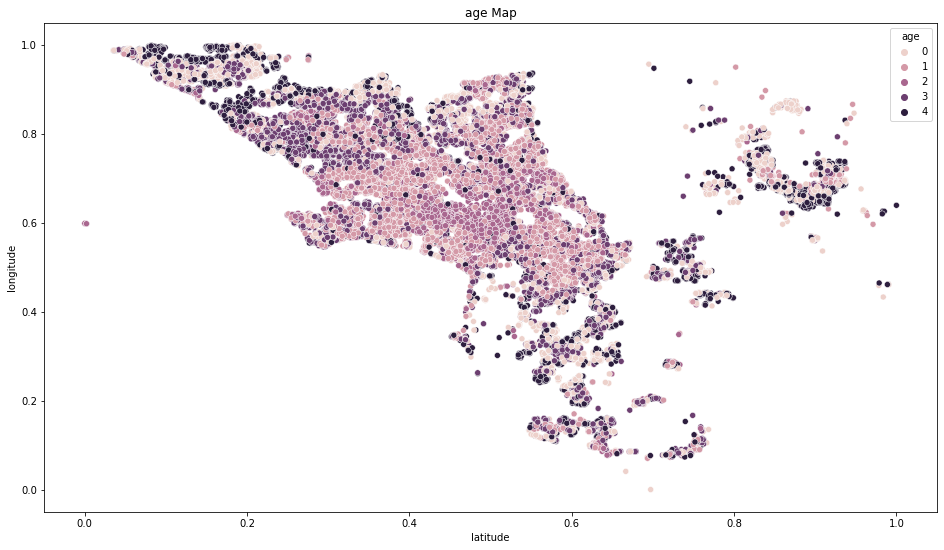

In [32]:
cluster.map_clusters(train_scaled, 'age')

## Cross Referencing our Big 3

### Size vs Price

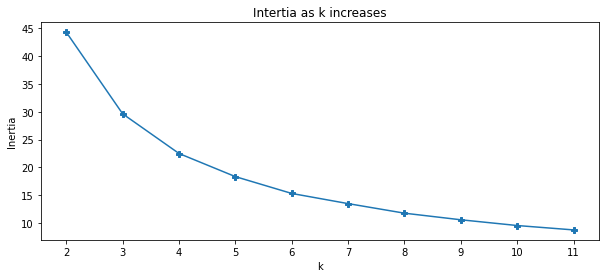

In [33]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
cluster.view_intertia(X)

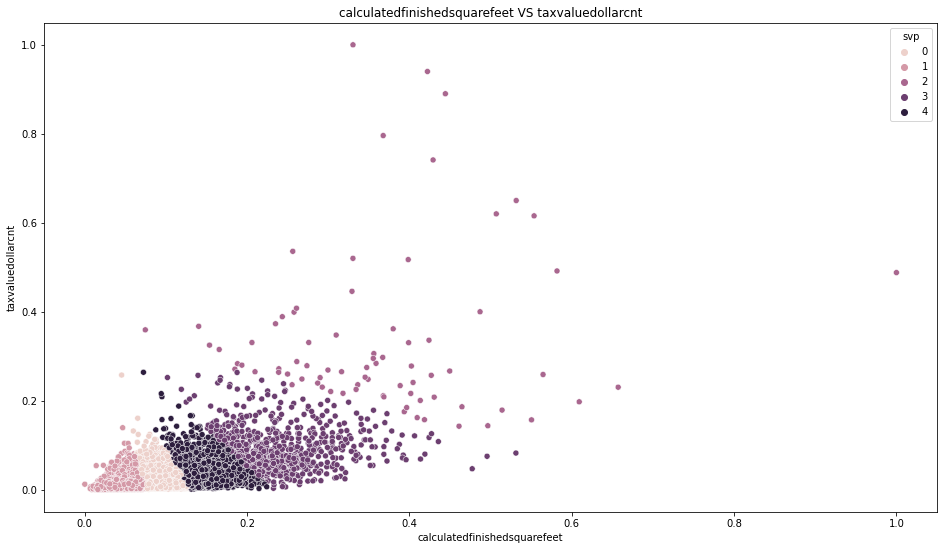

In [34]:
#Price by Size
X = cluster.show_cluster(X, 5, 'svp')

In [35]:
train_scaled['svp'] = X['svp']

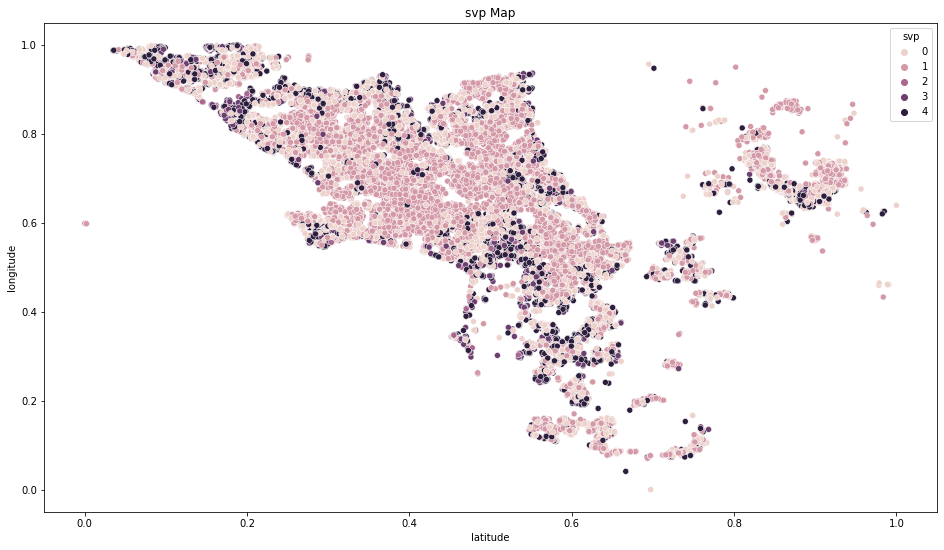

In [36]:
cluster.map_clusters(train_scaled, 'svp')

### Price vs Age

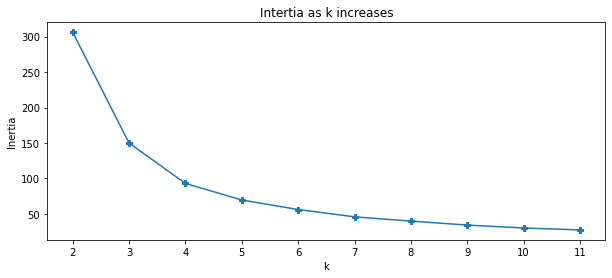

In [37]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

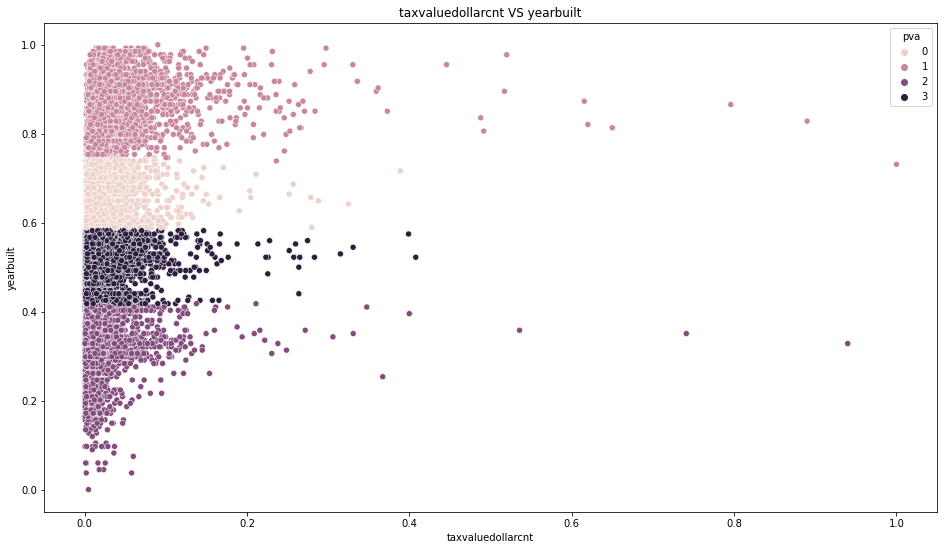

In [38]:
#price per age
X = cluster.show_cluster(X, 4, 'pva')

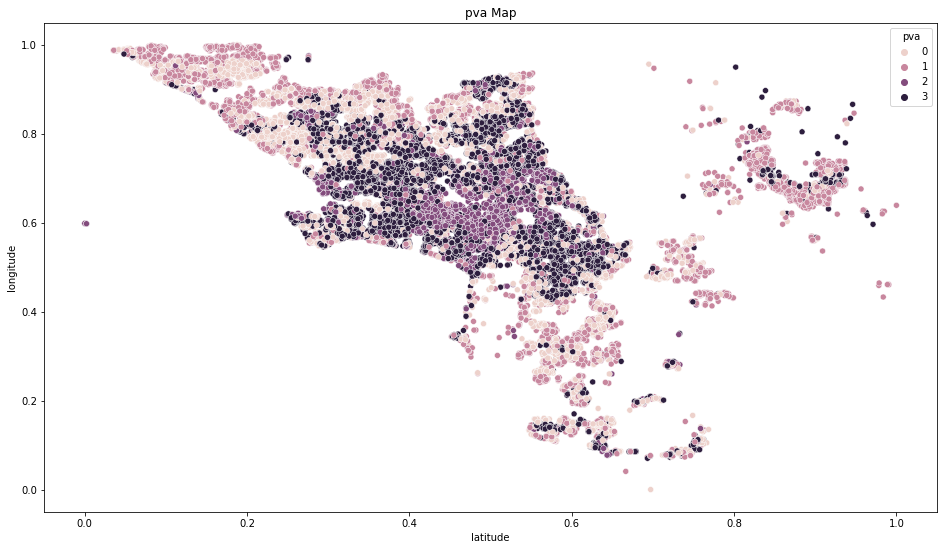

In [40]:
train_scaled['pva'] = X['pva']
cluster.map_clusters(train_scaled, 'pva')

### Age vs Size

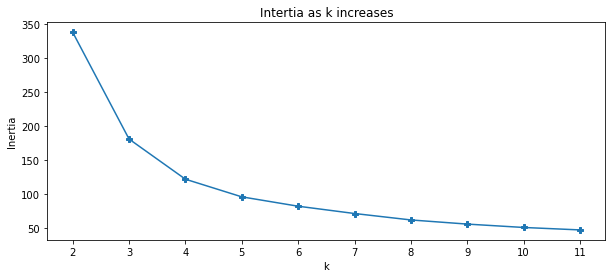

In [41]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

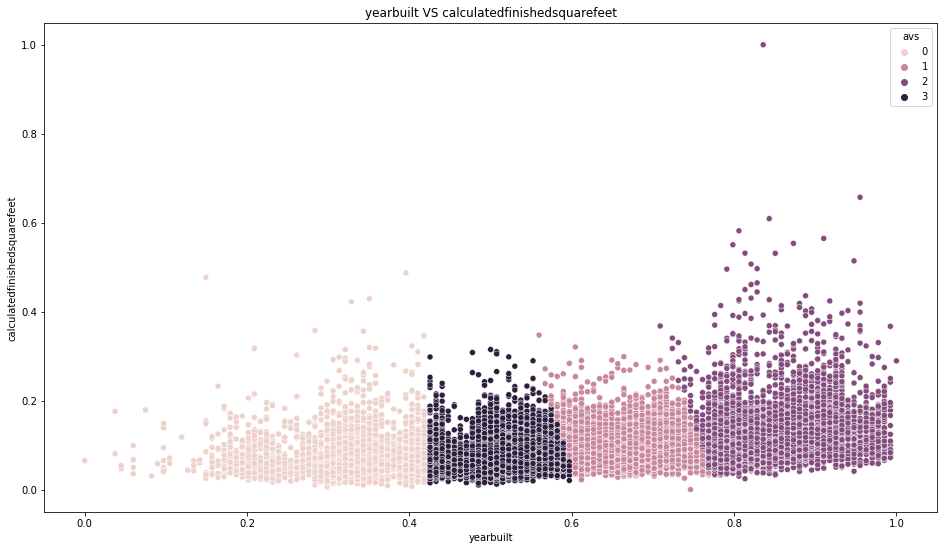

In [42]:
X = cluster.show_cluster(X, 4, 'avs')

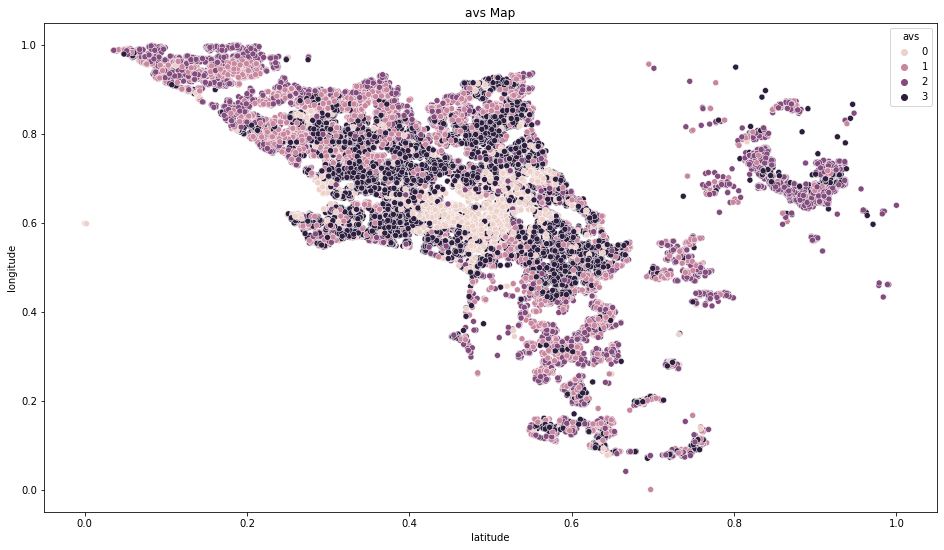

In [43]:
train_scaled['avs'] = X['avs']
cluster.map_clusters(train_scaled, 'avs')

## All 3

### Size vs Price vs Age

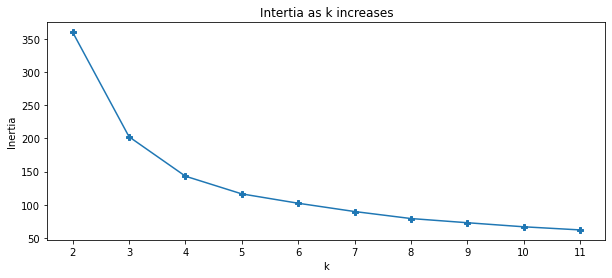

In [44]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

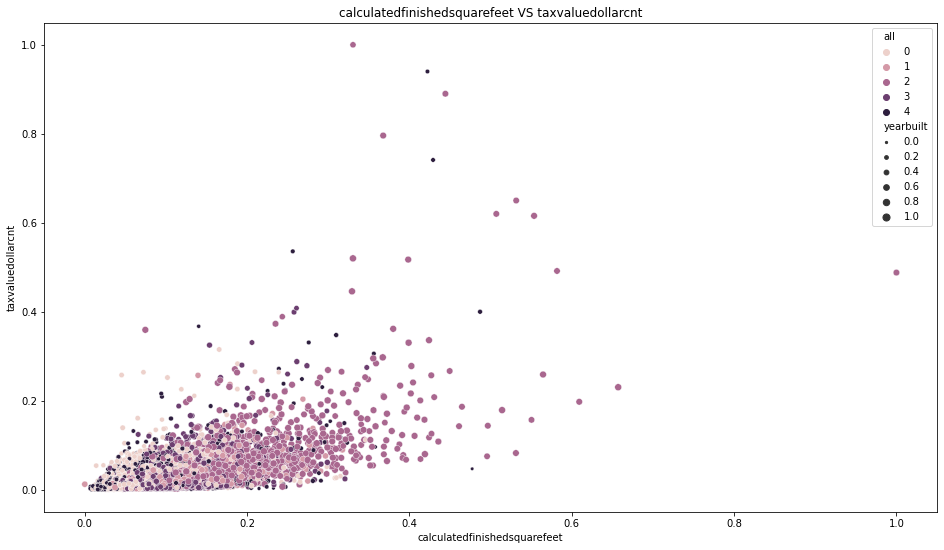

In [45]:
X = cluster.show_cluster(X, 5, 'all', 'yearbuilt')

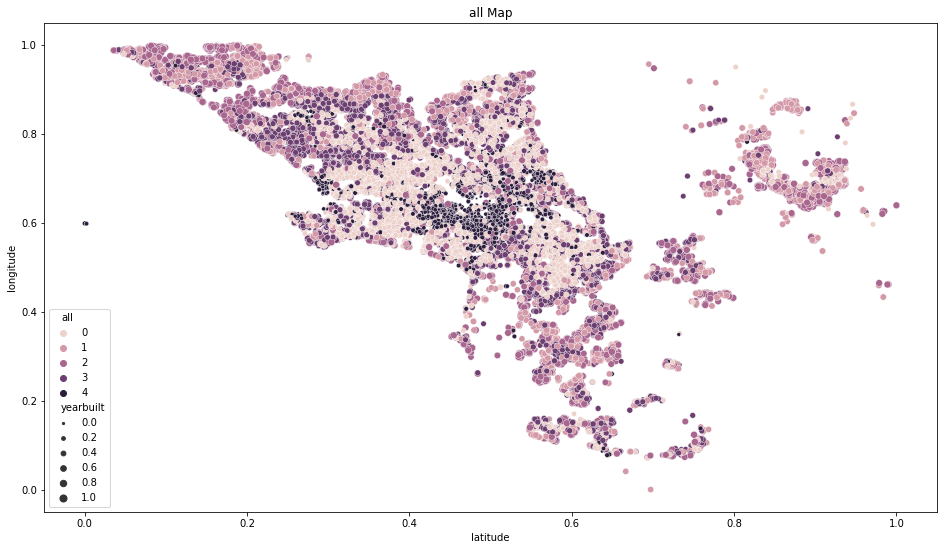

In [46]:
train_scaled['all'] = X['all']
cluster.map_clusters(train_scaled, 'all', 'yearbuilt' )

### Find Trend

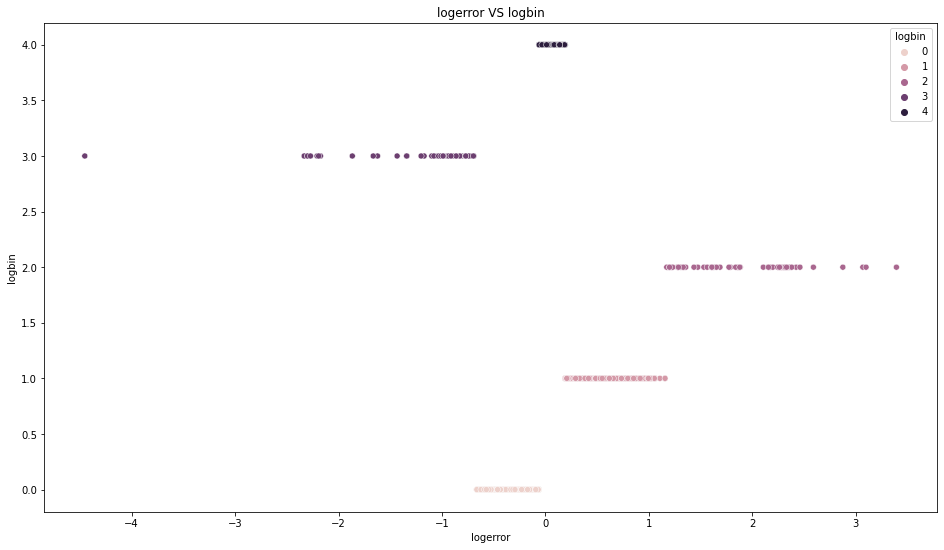

In [47]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 5, 'logbin',hide= False)
train_scaled['logbin'] = X['logbin']

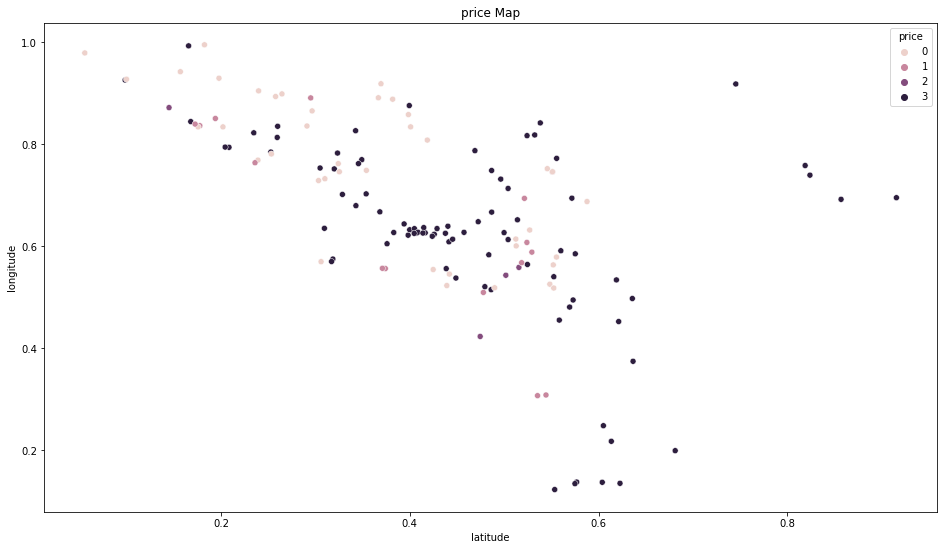

In [66]:
cluster.map_clusters(train_scaled[(train_scaled['logbin']== 3) | (train_scaled['logbin']== 2)], 'price')
#cluster.map_clusters(train_scaled, 'price')